# Modules

## install

In [ ]:
!pip install gym-trading-env

## import

In [1]:
import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import gymnasium as gym
from gym_trading_env.downloader import download


import random
from collections import deque, namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Utils

In [2]:
def moving_average(data, window_size):
    weights = np.repeat(1.0, window_size) / window_size
    return np.convolve(data, weights, 'valid')

In [3]:
def plot_scores(scores, window_size=25):
    smoothed_scores = moving_average(scores, window_size)
    plt.figure(figsize=(10, 6))
    plt.plot(smoothed_scores)
    plt.title('Training Progress (Moving Average)')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.grid(True)
    plt.show()

In [4]:
def plot_financial_data(df):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10))

    df[['open', 'high', 'low', 'close']].plot(ax=axes[0], title='Price Data Over Time', grid=True)
    axes[0].set_ylabel('Price')

    df['volume'].plot(ax=axes[1], title='Volume Over Time', grid=True, color='orange')
    axes[1].set_ylabel('Volume')

    plt.tight_layout()
    plt.show()


In [5]:
def preprocess(df : pd.DataFrame):
  df["feature_close"] = df["close"].pct_change()
  df["feature_open"] = df["open"]/df["close"]
  df["feature_high"] = df["high"]/df["close"]
  df["feature_low"] = df["low"]/df["close"]
  df["feature_volume"] = df["volume"] / df["volume"].rolling(7*24).max()
  df.dropna(inplace= True)
  return df

# Financial Data

In [6]:
timeframe = 12

download(exchange_names = ["binance"],
    symbols= ["BTC/USDT"],
    timeframe= f"{timeframe}h",
    dir = "./data/train",
    since= datetime.datetime(year=2020, month=1, day=1),
    until= datetime.datetime(year=2022, month=12, day=31),
)

df_train = pd.read_pickle(f"./data/train/binance-BTCUSDT-{timeframe}h.pkl")

BTC/USDT downloaded from binance and stored at ./data/train/binance-BTCUSDT-12h.pkl


In [7]:
timeframe = 12

download(exchange_names = ["binance"],
    symbols= ["BTC/USDT"],
    timeframe= f"{timeframe}h",
    dir = "./data/test",
    since= datetime.datetime(year=2023, month=1, day=1),
)

df_test = pd.read_pickle(f"./data/test/binance-BTCUSDT-{timeframe}h.pkl")

BTC/USDT downloaded from binance and stored at ./data/test/binance-BTCUSDT-12h.pkl


In [8]:
df_train

,open,high,low,close,volume,date_close
date_open,,,,,,
2020-01-01 00:00:00,7195.24,7245.00,7175.46,7197.20,8061.698592,2020-01-01 12:00:00
2020-01-01 12:00:00,7197.20,7255.00,7175.15,7200.85,8730.689573,2020-01-02 00:00:00
2020-01-02 00:00:00,7200.77,7212.50,7105.00,7139.79,11959.519197,2020-01-02 12:00:00
2020-01-02 12:00:00,7139.73,7163.40,6924.74,6965.71,19991.964735,2020-01-03 00:00:00
2020-01-03 00:00:00,6965.49,7371.92,6871.04,7340.46,40220.086515,2020-01-03 12:00:00
...,...,...,...,...,...,...
2022-12-28 12:00:00,16678.52,16785.19,16465.33,16547.31,104376.815840,2022-12-29 00:00:00
2022-12-29 00:00:00,16547.32,16630.00,16488.91,16598.70,72980.359380,2022-12-29 12:00:00
2022-12-29 12:00:00,16598.70,16664.41,16555.57,16633.47,88018.112200,2022-12-30 00:00:00


In [9]:
df_train.shape[0], df_test.shape[0]

(2190, 906)

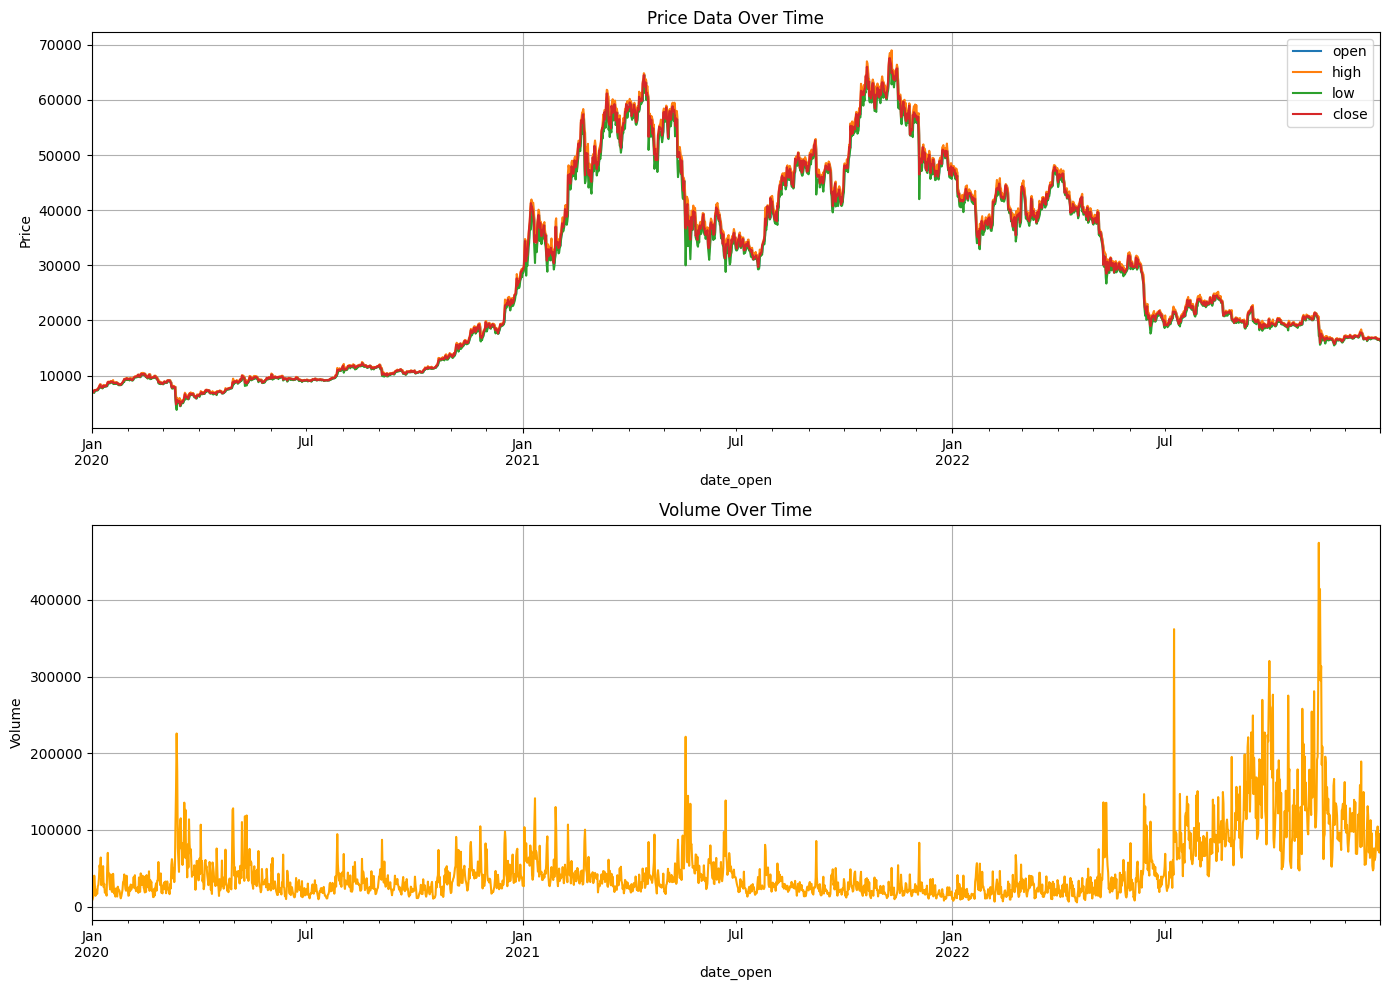

In [10]:
plot_financial_data(df_train)

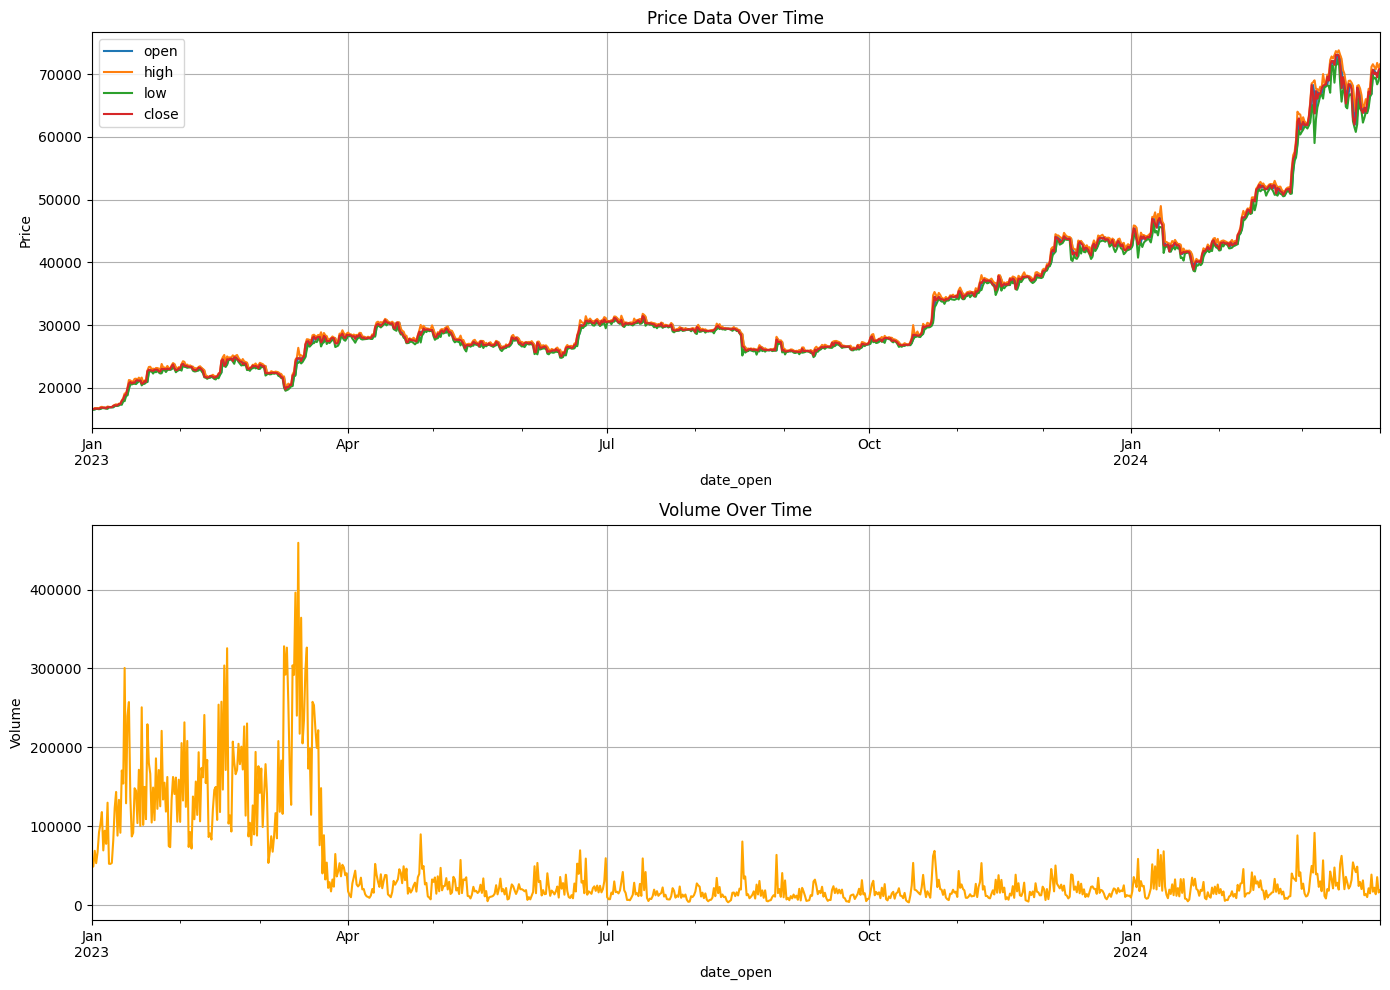

In [11]:
plot_financial_data(df_test)

In [12]:
df_train = preprocess(df_train)
df_test = preprocess(df_test)

# Environment

In [13]:
env_train = gym.make("TradingEnv",
        name= "BTCUSD",
        df = df_train,
        positions = [-1, 0, 1], # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate = 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        verbose = 0
    )

In [14]:
env_test = gym.make("TradingEnv",
        name= "BTCUSD",
        df = df_test,
        positions = [-1, 0, 1], # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
    )

In [15]:
env_train.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env_train.unwrapped.add_metric('Episode Lenght', lambda history : len(history['position']) )

env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env_test.unwrapped.add_metric('Episode Lenght', lambda history : len(history['position']) )

In [16]:
STATE_SIZE = env_train.observation_space.shape[0]
ACTION_SIZE = env_train.action_space.n
STATE_SIZE, ACTION_SIZE

(7, 3)

# Training

## DQN Network

In [17]:
class QNetwork(nn.Module):

    def __init__(self, state_size, action_size, hidden_neurons, seed):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, hidden_neurons)
        self.fc2 = nn.Linear(hidden_neurons, hidden_neurons)
        self.fc3 = nn.Linear(hidden_neurons, action_size)
        
    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

## Replay Buffer

In [18]:
class ReplayBuffer:

    def __init__(self, action_size, buffer_size, batch_size, seed):

        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

## Agent

In [19]:
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 256
GAMMA = 0.99
TAU = 1e-3
LR = 1e-3
UPDATE_EVERY = 4
NEURONS = 256

In [20]:
class Agent():

    def __init__(self, state_size, action_size, hidden_neurons, seed):

        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        self.qnetwork_local = QNetwork(state_size, action_size, hidden_neurons, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, hidden_neurons, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
 
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):

        states, actions, rewards, next_states, dones = experiences

        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        q_expected = self.qnetwork_local(states).gather(1, actions)
        
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                

    def soft_update(self, local_model, target_model, tau):

        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

## Training Loop

In [21]:
def dqn(agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, print_every=25, checkpoint_every=250):

    scores = []                        
    scores_window = deque(maxlen=100)
    eps = eps_start
    
    for i_episode in range(1, n_episodes+1):
        state, _ = env_train.reset()
        score = 0
        done = False
        while not done:
            action = agent.act(state, eps)
            next_state, reward, terminated, truncated, _ = env_train.step(action)
            done = terminated or truncated
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
            
        scores_window.append(score)       
        scores.append(score)              
        eps = max(eps_end, eps_decay*eps)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if i_episode % checkpoint_every == 0:
            torch.save(agent.qnetwork_local.state_dict(), f'./checkpoints/checkpoint-{i_episode}.pth')
    return scores

## Run

In [22]:
agent = Agent(state_size=STATE_SIZE, action_size=ACTION_SIZE, hidden_neurons=NEURONS, seed=0)

In [ ]:
scores = dqn(agent=agent, n_episodes=2000, print_every=50, checkpoint_every=500)

In [ ]:
plot_scores(scores, window_size=50)

# Simulation

## Random Agent

In [25]:
done, truncated = False, False
observation, info = env_test.reset()
while not done and not truncated:
    action = env_train.action_space.sample()
    observation, reward, done, truncated, info = env_test.step(action)
    env_test.unwrapped.save_for_render(dir = "render_logs/random/")

Market Return : 157.94%   |   Portfolio Return : -16.68%   |   Position Changes : 503   |   Episode Lenght : 739   |   


## Learned Agent

In [26]:
agent = Agent(state_size=STATE_SIZE, action_size=ACTION_SIZE, hidden_neurons=NEURONS, seed=0)
agent.qnetwork_local.load_state_dict(torch.load('./checkpoints/checkpoint-2000.pth'))

<All keys matched successfully>

In [30]:
done, truncated = False, False
observation, info = env_train.reset()

while not done and not truncated:
    action = agent.act(observation)
    observation, reward, done, truncated, info = env_train.step(action)
    env_train.unwrapped.save_for_render(dir = "render_logs/train/")

In [29]:
done, truncated = False, False
observation, info = env_test.reset()

while not done and not truncated:
    action = agent.act(observation)
    observation, reward, done, truncated, info = env_test.step(action)
    env_test.unwrapped.save_for_render(dir = "render_logs/agent/")

Market Return : 157.94%   |   Portfolio Return : 157.88%   |   Position Changes : 1   |   Episode Lenght : 739   |   
